In [133]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

from sklearn.preprocessing import MinMaxScaler

In [116]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

In [117]:
actions = oracle_reversed_data['actions']
actions = [[i] for i in actions]

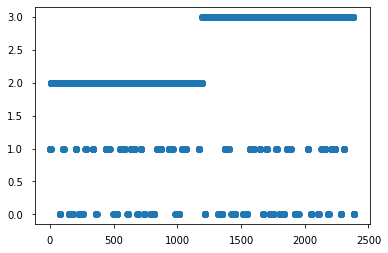

In [118]:
plt.plot(actions, "o")
plt.show()

In [119]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data

training_data = actions


seq_length = 4
x, y = sliding_windows(training_data, seq_length)



# one method of performing the training and validation split
train_size = int(len(y) * 0.80)
test_size = len(y) - train_size


# shuffle data first before splitting
idx_shuf = list(range(len(y)))
random.shuffle(idx_shuf)
x = [x[i] for i in idx_shuf]
y = [y[i] for i in idx_shuf]

# split data
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))

In [120]:
k = 6
print('sequence:', x[k])
print('label:', y[k])

sequence: [[0]
 [0]
 [0]
 [0]]
label: [0]


In [121]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [158]:
value = 0

test_input = trainX[value:value+1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

outputs = lstm(test_input)
print(outputs)

print("outputs:", outputs)
_, rounded_opt = torch.max(outputs, 1)
print("output rounded:", rounded_opt)
print("labels:", trainY[value:value+1])

print("")

outputs = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(outputs))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (1908, 1, 1), device="cpu"))

input length: 4
input (trainX): tensor([[[0.],
         [0.],
         [0.],
         [3.]]])
tensor([[-2.3725, -4.2009,  1.3206,  3.8579]], grad_fn=<AddmmBackward0>)
outputs: tensor([[-2.3725, -4.2009,  1.3206,  3.8579]], grad_fn=<AddmmBackward0>)
output rounded: tensor([3])
labels: tensor([[3.]])

length input (trainX): 1908
length outputs: 1908
length labels: 1908

SUMMARY LSTM 
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1908, 4]                 --
├─LSTM: 1-1                              [1908, 1, 20]             1,840
├─Linear: 1-2                            [1908, 4]                 84
Total params: 1,924
Trainable params: 1,924
Non-trainable params: 0
Total mult-adds (M): 3.67
Input size (MB): 0.01
Forward/backward pass size (MB): 0.37
Params size (MB): 0.01
Estimated Total Size (MB): 0.38


In [123]:
"""
best value: 0.07111 (hidden size of 20) - but overall little to no diff.
best value: 0.06789 (with a seq. length of 20)
increasing the length of the sequence length concidered 
for making the next decision, the better the resulting prediction

"""

num_epochs = 2000
learning_rate = 0.001

input_size = 1
hidden_size = 20
num_layers = 1

num_classes = 4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

#criterion = torch.nn.MSELoss()  # MSELoss - regression, CrossEntropyLoss for labels
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    optimizer.zero_grad()
    outputs = lstm(trainX)
    labels = trainY.to(torch.long)
    labels = labels[:, 0]
    
    loss = criterion(outputs, labels)
    loss.backward()
    
    # compute train acc
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    train_acc = correct / len(trainX)
    
    # compute test acc
    with torch.no_grad():
        outputs = lstm(testX)
        labels = testY.to(torch.long)
        labels = labels[:, 0]
        
        loss_test = criterion(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        test_acc = correct / len(testX)

    optimizer.step()
    if epoch % (num_epochs/20) == 0:
        print("Epoch: %d, train loss: %1.5f, train acc: %1.5f, test loss: %1.5f, test acc: %1.5f" % (epoch, loss.item(), train_acc, loss_test.item(), test_acc))

Epoch: 0, train loss: 1.38772, train acc: 0.41719, test loss: 1.39202, test acc: 0.40671
Epoch: 100, train loss: 0.95848, train acc: 0.78407, test loss: 0.91675, test acc: 0.80294
Epoch: 200, train loss: 0.58726, train acc: 0.77044, test loss: 0.53965, test acc: 0.78616
Epoch: 300, train loss: 0.44197, train acc: 0.86792, test loss: 0.38710, test acc: 0.90356
Epoch: 400, train loss: 0.38609, train acc: 0.86792, test loss: 0.33607, test acc: 0.90356
Epoch: 500, train loss: 0.34559, train acc: 0.90304, test loss: 0.30319, test acc: 0.92872
Epoch: 600, train loss: 0.31171, train acc: 0.91667, test loss: 0.27529, test acc: 0.93711
Epoch: 700, train loss: 0.28920, train acc: 0.93239, test loss: 0.25608, test acc: 0.94340
Epoch: 800, train loss: 0.27529, train acc: 0.93920, test loss: 0.24497, test acc: 0.95597
Epoch: 900, train loss: 0.26647, train acc: 0.93920, test loss: 0.23752, test acc: 0.95597
Epoch: 1000, train loss: 0.26033, train acc: 0.93920, test loss: 0.23148, test acc: 0.95597


In [124]:


print(len(predicted))
print(len(dataY))

labels = dataY.to(torch.long)
labels = labels[:, 0]

incorrect = [predicted == labels]
incorrect = incorrect[0].tolist()

477
2385


RuntimeError: The size of tensor a (477) must match the size of tensor b (2385) at non-singleton dimension 0

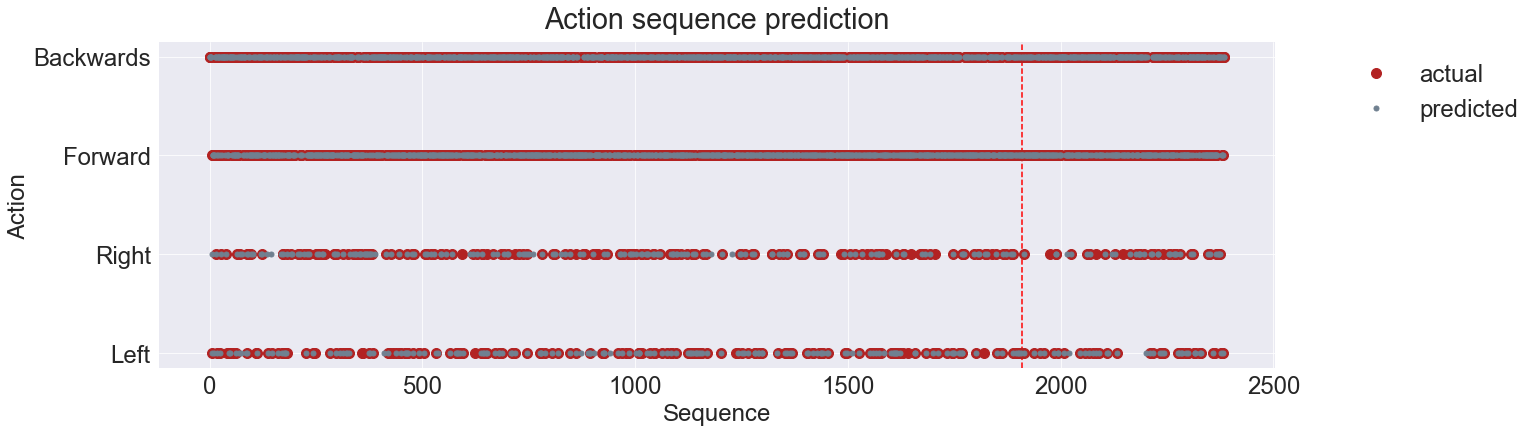

In [165]:
lstm.eval()
predict = lstm(dataX) # all data

_, predicted = torch.max(predict, 1)
data_predict = predicted.data.numpy()

dataY_plot = dataY.data.numpy()

font = 24
hfont = {'fontname':'Helvetica'}

plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'
plt.rcParams.update({"font.size": 24})

with plt.style.context("seaborn-darkgrid"):
    plt.figure(figsize=(20, 6))
    
    plt.axvline(x=train_size, c="r", linestyle="--")

    plt.plot(dataY_plot, "o", color='firebrick', markersize=10, label="actual")
    plt.plot(data_predict, "o", color="slategray", markersize=5, label="predicted")
    
    plt.yticks([0, 1, 2, 3], ['Left', 'Right', 'Forward', 'Backwards'])

    # plt.legend(['Training Acc', 'Validation Acc'])
    #plt.legend(loc="lower right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Action sequence prediction")
    plt.xlabel("Sequence", fontsize=font, **hfont)
    plt.ylabel("Action", fontsize=font, **hfont)
    plt.show()